Let's just get a quick sparsity overview of the methods so far.

In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as transforms


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

from torchvision.utils import save_image

import matplotlib.pyplot as plt
import math

In [2]:
import os
from os import listdir

In [3]:
#BASE_PATH_DATA = '../data/'
BASE_PATH_DATA = '/scratch/ns3429/sparse-subset/data/'

In [4]:
n_epochs = 50
batch_size = 64
lr = 0.002
b1 = 0.9
b2 = 0.999
img_size = 28
channels = 1

log_interval = 20


z_size = 40

n = 28 * 28

# from running
# EPSILON = np.finfo(tf.float32.as_numpy_dtype).tiny
#EPSILON = 1.1754944e-38
EPSILON = 1e-10

In [5]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")

In [6]:
print("Device")
print(device)

Device
cuda:0


In [7]:
np.random.seed(100)

In [8]:
import scipy.io as sio

In [9]:
a = sio.loadmat(BASE_PATH_DATA + 'zeisel/CITEseq.mat')
data= a['G'].T
N,d=data.shape
#transformation from integer entries 
data=np.log(data+np.ones(data.shape))
#for i in range(N):
for i in range(d):
    #data[i,:]=data[i,:]/np.linalg.norm(data[i,:])
    data[:,i]= (data[:,i] - np.min(data[:,i])) /  (np.max(data[:,i]) - np.min(data[:, i]))

#load labels from file
a = sio.loadmat(BASE_PATH_DATA + 'zeisel/CITEseq-labels.mat')
l_aux = a['labels']
labels = np.array([i for [i] in l_aux])

#load names from file
a = sio.loadmat(BASE_PATH_DATA + 'zeisel/CITEseq_names.mat')
names=[a['citeseq_names'][i][0][0] for i in range(N)]

In [10]:
slices = np.random.permutation(np.arange(data.shape[0]))
upto = int(.8 * len(data))

train_data = data[slices[:upto]]
test_data = data[slices[upto:]]

train_data = Tensor(train_data).to(device)
test_data = Tensor(test_data).to(device)

In [11]:
print(train_data.std(dim = 0).mean())
print(test_data.std(dim = 0).mean())

tensor(0.1832, device='cuda:0')
tensor(0.1824, device='cuda:0')


In [12]:
def loss_function_per_autoencoder(x, mu_x, logvar_x, mu_latent, logvar_latent):
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = F.mse_loss(recon_x, x, reduction='sum')
    loss_rec = -torch.sum(
            (-0.5 * np.log(2.0 * np.pi))
            + (-0.5 * logvar_x)
            + ((-0.5 / torch.exp(logvar_x)) * (x - mu_x) ** 2.0))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar_latent - mu_latent.pow(2) - logvar_latent.exp())
    #print(loss_rec.item(), KLD.item())
    return loss_rec + 130640 * KLD

In [13]:
# KLD of D(P_1||P_2) where P_i are Gaussians, assuming diagonal
def kld_joint_autoencoders(mu_1, mu_2, logvar_1, logvar_2):
    # equation 6 of Tutorial on Variational Autoencoders by Carl Doersch
    # https://arxiv.org/pdf/1606.05908.pdf
    mu_12 = mu_1 - mu_2
    kld = 0.5 * (-1 - (logvar_1 - logvar_2) + mu_12.pow(2) / logvar_2.exp() + torch.exp(logvar_1 - logvar_2))
    #print(kld.shape)
    kld = torch.sum(kld, dim = 1)
    
    return kld.sum()

In [14]:
# for joint
def loss_function_joint(x, ae_1, ae_2):
    # assuming that both autoencoders return recon_x, mu, and logvar
    # try to make ae_1 the vanilla vae
    # ae_2 should be the L1 penalty VAE
    mu_x_1, logvar_x_1, mu_latent_1, logvar_latent_1 = ae_1(x)
    mu_x_2, logvar_x_2, mu_latent_2, logvar_latent_2 = ae_2(x)
    
    loss_vae_1 = loss_function_per_autoencoder(x, mu_x_1, logvar_x_1, mu_latent_1, logvar_latent_1)
    loss_vae_2 = loss_function_per_autoencoder(x, mu_x_2, logvar_x_2, mu_latent_2, logvar_latent_2)
    joint_kld_loss = kld_joint_autoencoders(mu_latent_1, mu_latent_2, logvar_latent_1, logvar_latent_1)
    #print("Losses")
    #print(loss_vae_1)
    #print(loss_vae_2)
    #print(joint_kld_loss)
    return loss_vae_1, loss_vae_2, joint_kld_loss

Does L1 work if we normalize after every step?

In [15]:
# L1 VAE model we are loading
class VAE_l1_diag(nn.Module):
    def __init__(self, input_size, hidden_layer_size, z_size):
        super(VAE_l1_diag, self).__init__()
        
        self.diag = nn.Parameter(torch.normal(torch.zeros(input_size), 
                                 torch.ones(input_size)).to(device).requires_grad_(True))
        
        # self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, input_size)
        self.fc5 = nn.Linear(hidden_layer_size, input_size)
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU()
        )
        
        self.fc3_bn = nn.BatchNorm1d(hidden_layer_size)

    def encode(self, x):
        self.selection_layer = torch.diag(self.diag)
        h0 = torch.mm(x, self.selection_layer)
        h1 = self.encoder(h0)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.leaky_relu(self.fc3_bn(self.fc3(z)))
        mu_x = F.leaky_relu(self.fc4(h))
        #mu_x = self.fc4(h)
        logvar_x = self.fc5(h)
        return mu_x, logvar_x

    def forward(self, x):
        mu_latent, logvar_latent = self.encode(x)
        z = self.reparameterize(mu_latent, logvar_latent)
        mu_x, logvar_x = self.decode(z)
        return mu_x, logvar_x, mu_latent, logvar_latent


In [16]:
def train_l1(df, model, optimizer, epoch):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :]
        
        optimizer.zero_grad()
        mu_x, logvar_x, mu_latent, logvar_latent = model(batch_data)
        loss = loss_function_per_autoencoder(batch_data, mu_x, logvar_x, mu_latent, logvar_latent)
        loss += 1000000 * torch.norm(model.diag, p = 1)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        with torch.no_grad():
            model.diag.data /= torch.norm(model.diag.data, p = 2)
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data) / len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))
    
    


In [17]:
def test(df, model, epoch):
    model.eval()
    test_loss = 0
    inds = np.arange(df.shape[0])
    with torch.no_grad():
        for i in range(math.ceil(len(df)/batch_size)):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = df[batch_ind, :]
            batch_data = batch_data.to(device)
            mu_x, logvar_x, mu_latent, logvar_latent = model(batch_data)
            test_loss += loss_function_per_autoencoder(batch_data, mu_x, logvar_x, mu_latent, logvar_latent).item()


    test_loss /= len(df)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [18]:
model_l1_diag = VAE_l1_diag(500, 200, 50)

model_l1_diag.to(device)
model_l1_optimizer = torch.optim.Adam(model_l1_diag.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [19]:
for epoch in range(1, n_epochs + 1):
        train_l1(train_data, model_l1_diag, model_l1_optimizer, epoch)
        test(test_data, model_l1_diag, epoch)

Train Epoch: 1 [0/6893 (0%)]	Loss: 6169834.000000
Train Epoch: 1 [6400/6893 (1%)]	Loss: 288218.906250
====> Epoch: 1 Average loss: 344098.3992
====> Test set loss: 8770.4407
Train Epoch: 2 [0/6893 (0%)]	Loss: 288131.781250
Train Epoch: 2 [6400/6893 (1%)]	Loss: 287063.312500
====> Epoch: 2 Average loss: 288326.8821
====> Test set loss: 8220.0041
Train Epoch: 3 [0/6893 (0%)]	Loss: 286978.156250
Train Epoch: 3 [6400/6893 (1%)]	Loss: 285950.031250
====> Epoch: 3 Average loss: 287193.5015
====> Test set loss: 7703.1105
Train Epoch: 4 [0/6893 (0%)]	Loss: 285867.375000
Train Epoch: 4 [6400/6893 (1%)]	Loss: 284867.125000
====> Epoch: 4 Average loss: 286097.8326
====> Test set loss: 7217.9443
Train Epoch: 5 [0/6893 (0%)]	Loss: 284785.968750
Train Epoch: 5 [6400/6893 (1%)]	Loss: 283805.968750
====> Epoch: 5 Average loss: 285027.1850
====> Test set loss: 6754.0759
Train Epoch: 6 [0/6893 (0%)]	Loss: 283733.593750
Train Epoch: 6 [6400/6893 (1%)]	Loss: 282774.875000
====> Epoch: 6 Average loss: 2839

Train Epoch: 48 [6400/6893 (1%)]	Loss: 254688.812500
====> Epoch: 48 Average loss: 255597.7020
====> Test set loss: 382.8043
Train Epoch: 49 [0/6893 (0%)]	Loss: 254654.687500
Train Epoch: 49 [6400/6893 (1%)]	Loss: 254221.046875
====> Epoch: 49 Average loss: 255124.2917
====> Test set loss: 378.4853
Train Epoch: 50 [0/6893 (0%)]	Loss: 254183.734375
Train Epoch: 50 [6400/6893 (1%)]	Loss: 253753.828125
====> Epoch: 50 Average loss: 254654.4989
====> Test set loss: 375.1201
Train Epoch: 51 [0/6893 (0%)]	Loss: 253722.093750
Train Epoch: 51 [6400/6893 (1%)]	Loss: 253285.156250
====> Epoch: 51 Average loss: 254184.2211
====> Test set loss: 370.9341
Train Epoch: 52 [0/6893 (0%)]	Loss: 253249.250000
Train Epoch: 52 [6400/6893 (1%)]	Loss: 252805.796875
====> Epoch: 52 Average loss: 253712.9378
====> Test set loss: 367.9999
Train Epoch: 53 [0/6893 (0%)]	Loss: 252782.937500
Train Epoch: 53 [6400/6893 (1%)]	Loss: 252338.640625
====> Epoch: 53 Average loss: 253238.9299
====> Test set loss: 364.8888


Train Epoch: 95 [6400/6893 (1%)]	Loss: 233003.468750
====> Epoch: 95 Average loss: 233840.7484
====> Test set loss: 236.4366
Train Epoch: 96 [0/6893 (0%)]	Loss: 232975.281250
Train Epoch: 96 [6400/6893 (1%)]	Loss: 232556.921875
====> Epoch: 96 Average loss: 233390.7688
====> Test set loss: 233.1021
Train Epoch: 97 [0/6893 (0%)]	Loss: 232528.250000
Train Epoch: 97 [6400/6893 (1%)]	Loss: 232111.109375
====> Epoch: 97 Average loss: 232942.6768
====> Test set loss: 229.8905
Train Epoch: 98 [0/6893 (0%)]	Loss: 232078.906250
Train Epoch: 98 [6400/6893 (1%)]	Loss: 231671.156250
====> Epoch: 98 Average loss: 232501.0731
====> Test set loss: 227.5249
Train Epoch: 99 [0/6893 (0%)]	Loss: 231639.375000
Train Epoch: 99 [6400/6893 (1%)]	Loss: 231229.718750
====> Epoch: 99 Average loss: 232059.4801
====> Test set loss: 223.9121
Train Epoch: 100 [0/6893 (0%)]	Loss: 231197.218750
Train Epoch: 100 [6400/6893 (1%)]	Loss: 230795.343750
====> Epoch: 100 Average loss: 231620.9520
====> Test set loss: 222.29

In [20]:
bins = [10**(-i) for i in range(10)]
bins.reverse()
bins += [10]
np.histogram(model_l1_diag.diag.abs().clone().detach().cpu().numpy(), bins = bins)

(array([  2,  22, 112,  17,   1,   5,  48, 274,  18,   0]),
 array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
        1.e-01, 1.e+00, 1.e+01]))

In [21]:
with torch.no_grad():
    train_pred = model_l1_diag(train_data[0:64, :])[0]
    train_pred[train_pred < 0.001] = 0 

    test_pred = model_l1_diag(test_data[0:64,:])[0]
    test_pred[test_pred < 0.001] = 0 

In [22]:
test_data[0, :]

tensor([0.5442, 0.6031, 0.4708, 0.5576, 0.3855, 0.5411, 0.5537, 0.4934, 0.5422,
        0.5011, 0.5007, 0.3545, 0.5559, 0.3670, 0.1785, 0.5369, 0.1804, 0.4077,
        0.4889, 0.6549, 0.4487, 0.3518, 0.3118, 0.6650, 0.3306, 0.3359, 0.5101,
        0.3252, 0.5532, 0.1821, 0.3380, 0.4546, 0.2051, 0.5097, 0.5571, 0.3372,
        0.3656, 0.5523, 0.3793, 0.3885, 0.4283, 0.5121, 0.5536, 0.5432, 0.3926,
        0.3274, 0.4116, 0.3199, 0.2978, 0.4827, 0.3418, 0.5646, 0.4051, 0.1440,
        0.3947, 0.2577, 0.4066, 0.3444, 0.3856, 0.4076, 0.3271, 0.4662, 0.1573,
        0.4680, 0.3788, 0.3458, 0.3526, 0.4697, 0.4621, 0.4787, 0.3839, 0.3931,
        0.3947, 0.3900, 0.5435, 0.3632, 0.3662, 0.3182, 0.1832, 0.3874, 0.4308,
        0.0000, 0.5779, 0.3885, 0.3562, 0.0000, 0.2672, 0.4513, 0.4471, 0.1637,
        0.4628, 0.0000, 0.1601, 0.1892, 0.4363, 0.1906, 0.3709, 0.1700, 0.0000,
        0.0000, 0.2522, 0.0000, 0.3841, 0.2080, 0.1686, 0.3274, 0.1560, 0.0000,
        0.0000, 0.4421, 0.0000, 0.2652, 

In [23]:
print(torch.sum(test_pred[0,:] != 0))
print(torch.sum(test_data[0,:] != 0))

tensor(444, device='cuda:0')
tensor(264, device='cuda:0')


In [24]:
with torch.no_grad():
    print(torch.sum((train_pred - train_data[0:64, :]).abs()) / 64/500)
    print(torch.sum((test_pred - test_data[0:64, :]).abs()) / 64/500)

tensor(0.1841, device='cuda:0')
tensor(0.1865, device='cuda:0')


First try Pretrained VAE and then gumble trick with it

Then try joint training VAE and Gumbel Model

In [25]:
# Vanilla VAE model
# try with gaussian decoder
class VAE(nn.Module):
    def __init__(self, input_size, hidden_layer_size, z_size):
        super(VAE, self).__init__()

        #self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, input_size)
        self.fc5 = nn.Linear(hidden_layer_size, input_size)
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU()
        )
        
        self.fc3_bn = nn.BatchNorm1d(hidden_layer_size)
        
        #self.decoder = nn.Sequential()

    def encode(self, x):
        #h1 = F.relu(self.fc1(x))
        h1 = self.encoder(x)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):    
        h = F.leaky_relu(self.fc3_bn(self.fc3(z)))
        mu_x = F.leaky_relu(self.fc4(h))
        #mu_x = self.fc4(h)
        logvar_x = self.fc5(h)
        return mu_x, logvar_x

    def forward(self, x):
        mu_latent, logvar_latent = self.encode(x)
        z = self.reparameterize(mu_latent, logvar_latent)
        mu_x, logvar_x = self.decode(z)
        return mu_x, logvar_x, mu_latent, logvar_latent


# Pretrain VAE First

In [26]:
pretrain_vae = VAE(500, 200, 50)

pretrain_vae.to(device)
pretrain_vae_optimizer = torch.optim.Adam(pretrain_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [27]:
def train(df, model, optimizer, epoch):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :]
        
        optimizer.zero_grad()
        mu_x, logvar_x, mu_latent, logvar_latent = model(batch_data)
        loss = loss_function_per_autoencoder(batch_data, mu_x, logvar_x, mu_latent, logvar_latent)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))
    
    


In [28]:
for epoch in range(1, n_epochs + 1):
        train(train_data, pretrain_vae, pretrain_vae_optimizer, epoch)
        test(test_data, pretrain_vae, epoch)

Train Epoch: 1 [0/6893 (0%)]	Loss: 11003.015625
Train Epoch: 1 [6400/6893 (1%)]	Loss: 9763.967773
====> Epoch: 1 Average loss: 10388.4728
====> Test set loss: 9695.3521
Train Epoch: 2 [0/6893 (0%)]	Loss: 9685.396484
Train Epoch: 2 [6400/6893 (1%)]	Loss: 8611.845703
====> Epoch: 2 Average loss: 9100.4957
====> Test set loss: 8506.8281
Train Epoch: 3 [0/6893 (0%)]	Loss: 8492.738281
Train Epoch: 3 [6400/6893 (1%)]	Loss: 7503.057617
====> Epoch: 3 Average loss: 7956.1889
====> Test set loss: 7390.9549
Train Epoch: 4 [0/6893 (0%)]	Loss: 7382.337402
Train Epoch: 4 [6400/6893 (1%)]	Loss: 6329.913574
====> Epoch: 4 Average loss: 6848.4586
====> Test set loss: 6292.4771
Train Epoch: 5 [0/6893 (0%)]	Loss: 6237.245605
Train Epoch: 5 [6400/6893 (1%)]	Loss: 5289.105469
====> Epoch: 5 Average loss: 5771.4324
====> Test set loss: 5244.8189
Train Epoch: 6 [0/6893 (0%)]	Loss: 5286.896973
Train Epoch: 6 [6400/6893 (1%)]	Loss: 4327.622070
====> Epoch: 6 Average loss: 4764.9922
====> Test set loss: 4284.3

Train Epoch: 50 [6400/6893 (1%)]	Loss: 546.936279
====> Epoch: 50 Average loss: 516.7711
====> Test set loss: 516.3924
Train Epoch: 51 [0/6893 (0%)]	Loss: 506.785828
Train Epoch: 51 [6400/6893 (1%)]	Loss: 507.812775
====> Epoch: 51 Average loss: 508.2960
====> Test set loss: 508.3170
Train Epoch: 52 [0/6893 (0%)]	Loss: 503.375854
Train Epoch: 52 [6400/6893 (1%)]	Loss: 482.785583
====> Epoch: 52 Average loss: 500.4318
====> Test set loss: 500.5266
Train Epoch: 53 [0/6893 (0%)]	Loss: 501.746094
Train Epoch: 53 [6400/6893 (1%)]	Loss: 483.465393
====> Epoch: 53 Average loss: 492.7492
====> Test set loss: 492.4154
Train Epoch: 54 [0/6893 (0%)]	Loss: 467.760437
Train Epoch: 54 [6400/6893 (1%)]	Loss: 483.972351
====> Epoch: 54 Average loss: 485.3140
====> Test set loss: 485.0994
Train Epoch: 55 [0/6893 (0%)]	Loss: 473.254120
Train Epoch: 55 [6400/6893 (1%)]	Loss: 477.762390
====> Epoch: 55 Average loss: 477.9699
====> Test set loss: 478.7003
Train Epoch: 56 [0/6893 (0%)]	Loss: 494.800476
Trai

Train Epoch: 100 [6400/6893 (1%)]	Loss: 264.254974
====> Epoch: 100 Average loss: 267.6345
====> Test set loss: 269.6333


In [29]:
with torch.no_grad():
    train_pred = pretrain_vae(train_data[0:64, :])[0]
    train_pred[train_pred < 0.001] = 0 

    test_pred = pretrain_vae(test_data[0:64,:])[0]
    test_pred[test_pred < 0.001] = 0 

In [30]:
with torch.no_grad():
    print(torch.sum((train_pred - train_data[0:64, :]).abs()) / 64/500)
    print(torch.sum((test_pred - test_data[0:64, :]).abs()) / 64/500)

tensor(0.1827, device='cuda:0')
tensor(0.1834, device='cuda:0')


In [31]:
print(torch.sum(test_pred[0,:] != 0))
print(torch.sum(test_data[0,:] != 0))

tensor(430, device='cuda:0')
tensor(264, device='cuda:0')


In [32]:
for p in pretrain_vae.parameters():
    p.requires_grad = False

In [33]:
pretrain_vae.requires_grad_(False)

VAE(
  (fc21): Linear(in_features=200, out_features=50, bias=True)
  (fc22): Linear(in_features=200, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=500, bias=True)
  (fc5): Linear(in_features=200, out_features=500, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=500, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)

## Train Gumbel with the Pre-Trained VAE

In [34]:
def train_pre_trained(df, model, optimizer, epoch, pretrained_model):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :]
        
        optimizer.zero_grad()
        mu_x, logvar_x, mu_latent, logvar_latent = model(batch_data)
        with torch.no_grad():
            _, _, mu_latent_2, logvar_latent_2 = pretrained_model(batch_data)
        
        loss = loss_function_per_autoencoder(batch_data, mu_x, logvar_x, mu_latent, logvar_latent)
        loss += 1000*F.mse_loss(mu_latent, mu_latent_2, reduction = 'sum')
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))

In [35]:
def gumbel_keys(w):
    # sample some gumbels
    uniform = (1.0 - EPSILON) * torch.rand_like(w) + EPSILON
    z = torch.log(-torch.log(uniform))
    w = w + z
    return w


#equations 3 and 4 and 5
def continuous_topk(w, k, t, separate=False):
    softmax = nn.Softmax(dim = -1)
    khot_list = []
    onehot_approx = torch.zeros_like(w, dtype = torch.float32)
    for i in range(k):
        ### conver the following into pytorch
        #khot_mask = tf.maximum(1.0 - onehot_approx, EPSILON)
        max_mask = 1 - onehot_approx < EPSILON
        khot_mask = 1 - onehot_approx
        khot_mask[max_mask] = EPSILON
        
        w += torch.log(khot_mask)
        #onehot_approx = tf.nn.softmax(w / t, axis=-1)
        onehot_approx = softmax(w/t)
        khot_list.append(onehot_approx)
    if separate:
        return torch.stack(khot_list)
    else:
        return torch.sum(torch.stack(khot_list), dim = 0) 


def sample_subset(w, k, t=0.1):
    '''
    Args:
        w (Tensor): Float Tensor of weights for each element. In gumbel mode
            these are interpreted as log probabilities
        k (int): number of elements in the subset sample
        t (float): temperature of the softmax
    '''
    w = gumbel_keys(w)
    return continuous_topk(w, k, t)

In [36]:
# L1 VAE model we are loading
class VAE_Gumbel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, z_size, k, t = 0.1):
        super(VAE_Gumbel, self).__init__()
        
        self.k = k
        self.t = t
        
        self.weight_creator = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, input_size)
        )
        
        #self.fc1 = nn.Linear(input_size, hidden_layer_size)
        #self.fcextra = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, input_size)
        self.fc5 = nn.Linear(hidden_layer_size, input_size)
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU()
        )
        
        self.fc3_bn = nn.BatchNorm1d(hidden_layer_size)

    def encode(self, x):
        w = self.weight_creator(x)
        subset_indices = sample_subset(w, self.k, self.t)
        x = x * subset_indices
        h1 = self.encoder(x)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.leaky_relu(self.fc3_bn(self.fc3(z)))
        mu_x = F.leaky_relu(self.fc4(h))
        #mu_x = self.fc4(h)
        logvar_x = self.fc5(h)
        return mu_x, logvar_x

    def forward(self, x):
        mu_latent, logvar_latent = self.encode(x)
        z = self.reparameterize(mu_latent, logvar_latent)
        mu_x, logvar_x = self.decode(z)
        return mu_x, logvar_x, mu_latent, logvar_latent


In [37]:
vae_gumbel_with_pre = VAE_Gumbel(500, 200, 50, k = 50)
vae_gumbel_with_pre.to(device)
vae_gumbel_with_pre_optimizer = torch.optim.Adam(vae_gumbel_with_pre.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [38]:
for epoch in range(1, n_epochs + 1):
        train_pre_trained(train_data, vae_gumbel_with_pre, vae_gumbel_with_pre_optimizer, epoch, pretrain_vae)
        test(test_data, vae_gumbel_with_pre, epoch)

Train Epoch: 1 [0/6893 (0%)]	Loss: 9236.722656
Train Epoch: 1 [6400/6893 (1%)]	Loss: 8699.991211
====> Epoch: 1 Average loss: 8949.6141
====> Test set loss: 8578.5354
Train Epoch: 2 [0/6893 (0%)]	Loss: 8662.710938
Train Epoch: 2 [6400/6893 (1%)]	Loss: 8150.341797
====> Epoch: 2 Average loss: 8393.2081
====> Test set loss: 8047.3223
Train Epoch: 3 [0/6893 (0%)]	Loss: 8125.241699
Train Epoch: 3 [6400/6893 (1%)]	Loss: 7671.884766
====> Epoch: 3 Average loss: 7866.0143
====> Test set loss: 7537.4988
Train Epoch: 4 [0/6893 (0%)]	Loss: 7594.772949
Train Epoch: 4 [6400/6893 (1%)]	Loss: 7150.710938
====> Epoch: 4 Average loss: 7361.1178
====> Test set loss: 7047.1213
Train Epoch: 5 [0/6893 (0%)]	Loss: 7114.481445
Train Epoch: 5 [6400/6893 (1%)]	Loss: 6651.139648
====> Epoch: 5 Average loss: 6862.9495
====> Test set loss: 6556.3174
Train Epoch: 6 [0/6893 (0%)]	Loss: 6635.752441
Train Epoch: 6 [6400/6893 (1%)]	Loss: 6135.333496
====> Epoch: 6 Average loss: 6369.3400
====> Test set loss: 6068.134

Train Epoch: 50 [6400/6893 (1%)]	Loss: 443.265930
====> Epoch: 50 Average loss: 441.7853
====> Test set loss: 435.8204
Train Epoch: 51 [0/6893 (0%)]	Loss: 431.146576
Train Epoch: 51 [6400/6893 (1%)]	Loss: 435.620270
====> Epoch: 51 Average loss: 434.8804
====> Test set loss: 429.6375
Train Epoch: 52 [0/6893 (0%)]	Loss: 435.378540
Train Epoch: 52 [6400/6893 (1%)]	Loss: 414.201660
====> Epoch: 52 Average loss: 427.8811
====> Test set loss: 424.9954
Train Epoch: 53 [0/6893 (0%)]	Loss: 433.152069
Train Epoch: 53 [6400/6893 (1%)]	Loss: 426.823181
====> Epoch: 53 Average loss: 422.2638
====> Test set loss: 416.5564
Train Epoch: 54 [0/6893 (0%)]	Loss: 421.890350
Train Epoch: 54 [6400/6893 (1%)]	Loss: 405.016052
====> Epoch: 54 Average loss: 415.3515
====> Test set loss: 411.7351
Train Epoch: 55 [0/6893 (0%)]	Loss: 398.312805
Train Epoch: 55 [6400/6893 (1%)]	Loss: 420.354401
====> Epoch: 55 Average loss: 408.9861
====> Test set loss: 404.1925
Train Epoch: 56 [0/6893 (0%)]	Loss: 415.611481
Trai

====> Test set loss: 234.0084
Train Epoch: 100 [0/6893 (0%)]	Loss: 239.565933
Train Epoch: 100 [6400/6893 (1%)]	Loss: 230.973328
====> Epoch: 100 Average loss: 233.7206
====> Test set loss: 231.7543


In [39]:
with torch.no_grad():
    train_pred = vae_gumbel_with_pre(train_data[0:64, :])[0]
    train_pred[train_pred < 0.001] = 0 

    test_pred = vae_gumbel_with_pre(test_data[0:64,:])[0]
    test_pred[test_pred < 0.001] = 0 

In [40]:
with torch.no_grad():
    print(torch.sum((train_pred - train_data[0:64, :]).abs()) / 64/500)
    print(torch.sum((test_pred - test_data[0:64, :]).abs()) / 64/500)

tensor(0.1859, device='cuda:0')
tensor(0.1849, device='cuda:0')


In [41]:
print(torch.sum(test_pred[0,:] != 0))
print(torch.sum(test_data[0,:] != 0))

tensor(446, device='cuda:0')
tensor(264, device='cuda:0')


# Joint Training

In [42]:
# model 1 should be vanilla

def train_joint(df, model1, model2, optimizer, epoch):
    model1.train()
    model2.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :]
        
        optimizer.zero_grad()

        
        loss_vae_1, loss_vae_2, joint_kld_loss = loss_function_joint(batch_data, model1, model2)
        loss = (loss_vae_1 + loss_vae_2 + 1000 * joint_kld_loss)
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))

In [43]:
def test_joint(df, model1, model2, epoch):
    model1.eval()
    model2.eval()
    test_loss = 0
    inds = np.arange(df.shape[0])
    with torch.no_grad():
        for i in range(math.ceil(len(df)/batch_size)):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = df[batch_ind, :]
            batch_data = batch_data.to(device)
            loss_vae_1, loss_vae_2, joint_kld_loss = loss_function_joint(batch_data, model1, model2)
        
            test_loss += (loss_vae_1 + loss_vae_2 + 1000 * joint_kld_loss).item()


    test_loss /= len(df)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [44]:
joint_vanilla_vae = VAE(500, 200, 50)
joint_vanilla_vae.to(device)

joint_vae_gumbel = VAE_Gumbel(500, 200, 50, k = 50)
joint_vae_gumbel.to(device)


joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + list(joint_vae_gumbel.parameters()), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [45]:
for epoch in range(1, n_epochs + 1):
    train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch)
    test_joint(test_data, joint_vanilla_vae, joint_vae_gumbel, epoch)

Train Epoch: 1 [0/6893 (0%)]	Loss: 23476.283203
Train Epoch: 1 [6400/6893 (1%)]	Loss: 21387.679688
====> Epoch: 1 Average loss: 22362.1970
====> Test set loss: 21281.3498
Train Epoch: 2 [0/6893 (0%)]	Loss: 21306.634766
Train Epoch: 2 [6400/6893 (1%)]	Loss: 19388.736328
====> Epoch: 2 Average loss: 20301.2954
====> Test set loss: 19339.7691
Train Epoch: 3 [0/6893 (0%)]	Loss: 19285.892578
Train Epoch: 3 [6400/6893 (1%)]	Loss: 17649.837891
====> Epoch: 3 Average loss: 18424.3846
====> Test set loss: 17506.8465
Train Epoch: 4 [0/6893 (0%)]	Loss: 17461.537109
Train Epoch: 4 [6400/6893 (1%)]	Loss: 15772.488281
====> Epoch: 4 Average loss: 16598.7503
====> Test set loss: 15695.4505
Train Epoch: 5 [0/6893 (0%)]	Loss: 15659.019531
Train Epoch: 5 [6400/6893 (1%)]	Loss: 13970.343750
====> Epoch: 5 Average loss: 14825.5477
====> Test set loss: 13966.9555
Train Epoch: 6 [0/6893 (0%)]	Loss: 13997.325195
Train Epoch: 6 [6400/6893 (1%)]	Loss: 12492.328125
====> Epoch: 6 Average loss: 13148.8052
====> 

KeyboardInterrupt: 

In [46]:
with torch.no_grad():
    train_pred = joint_vae_gumbel(train_data[0:64, :])[0]
    train_pred[train_pred < 0.001] = 0 

    test_pred = joint_vae_gumbel(test_data[0:64,:])[0]
    test_pred[test_pred < 0.001] = 0 

In [47]:
with torch.no_grad():
    print(torch.sum((train_pred - train_data[0:64, :]).abs()) / 64/500)
    print(torch.sum((test_pred - test_data[0:64, :]).abs()) / 64/500)

tensor(0.1934, device='cuda:0')
tensor(0.1961, device='cuda:0')


In [48]:
print(torch.sum(test_pred[0,:] != 0))
print(torch.sum(test_data[0,:] != 0))

tensor(433, device='cuda:0')
tensor(264, device='cuda:0')


### Let's actually Garph this.

### Try it out at Gumbel sparsity of k = 10, 25, 50, 100, 250

### Graph Test MSE Loss

## Graph the mean activations at k = 50

In [59]:
def graph_activations(test_data, model, title, file):
    preds, _, _, _ = model(test_data)
    
    pred_activations = preds.mean(dim = 0)
    
    test_activations = test_data.mean(dim = 0)
    
    x = np.arange(500) + 1
    
    fig = plt.figure()
    plt.plot(x, pred_activations.clone().detach().cpu().numpy(), label = 'Average Predictions')
    plt.plot(x, test_activations.clone().detach().cpu().numpy(), label = 'Average Test Data')
    
    plt.title(title)
    
    plt.legend()
    plt.savefig(file)

In [ ]:
graph_activations(test_data, model_l1_diag, 'Joint Gumbel vs Test Means', 
                  '/scratch/ns3429/sparse-subset/vae_l1.png')

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/ns3429/sparse-subset/joint_gumbel.png'

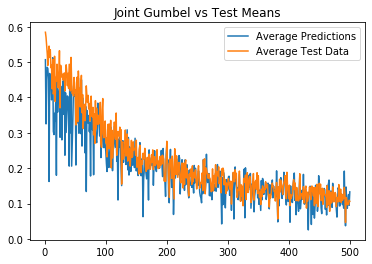

In [60]:
graph_activations(test_data, joint_vae_gumbel, 'Joint Gumbel vs Test Means', 
                  '/scratch/ns3429/sparse-subset/joint_gumbel.png')

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/ns3429/sparse-subset/pretrained_gumbel.png'

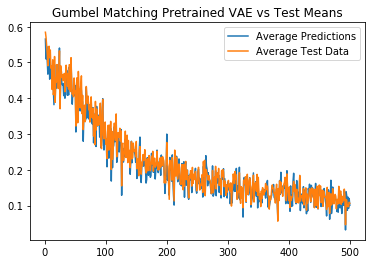

In [62]:
graph_activations(test_data, vae_gumbel_with_pre, 'Gumbel Matching Pretrained VAE vs Test Means', 
                  '/scratch/ns3429/sparse-subset/pretrained_gumbel.png')

In [61]:
k_all = [5, 10, 15, 20, 25, 30, 40, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375,
         400, 425, 450]
n_trials = 10

In [ ]:
losses_pre = []
losses_joint = []

In [ ]:
for k in k_all:
    current_k_pre_losses = []
    current_k_joint_losses = []
    for trial_i in range(n_trials):
        print("RUNNING for K {} Trial {}".format(k, trial_i), flush=True)
        vae_gumbel_with_pre = VAE_Gumbel(500, 200, 50, k = k)
        vae_gumbel_with_pre.to(device)
        vae_gumbel_with_pre_optimizer = torch.optim.Adam(vae_gumbel_with_pre.parameters(), 
                                                        lr=lr, 
                                                        betas = (b1,b2))
    
        joint_vanilla_vae = VAE(500, 200, 50)
        joint_vanilla_vae.to(device)

        joint_vae_gumbel = VAE_Gumbel(500, 200, 50, k = k)
        joint_vae_gumbel.to(device)


        joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + 
                                           list(joint_vae_gumbel.parameters()),
                                                lr=lr, 
                                                betas = (b1,b2))
    
        for epoch in (1, n_epochs + 1):
            train_pre_trained(train_data, vae_gumbel_with_pre, vae_gumbel_with_pre_optimizer, epoch, pretrain_vae)
            train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch)
    
        test_pred_pre = vae_gumbel_with_pre(test_data)[0]
        test_pred_pre[test_pred_pre < 0.001] = 0 
    
        test_pred_joint = joint_vanilla_vae(test_data)[0]
        test_pred_joint[test_pred_joint < 0.001] = 0
    
        with torch.no_grad():
            mae_pre = torch.sum((test_pred_pre - test_data).abs()) / len(test_data) / 500
            mae_joint = torch.sum((test_pred_joint - test_data).abs()) / len(test_data) / 500
        
        current_k_pre_losses.append(mae_pre.cpu().item())
        current_k_joint_losses.append(mae_joint.cpu().item())
        
        # for freeing memory faster
        # but not too fast
        if (trial+1) % 2 == 0:
            del vae_gumbel_with_pre
            del vae_gumbel_with_pre_optimizer
            del joint_vanilla_vae
            del joint_vae_gumbel
            del joint_optimizer
            del test_pred_pre
            del test_pred_joint

            torch.cuda.empty_cache()
        
    
    losses_pre.append(np.mean(current_k_pre_losses))
    losses_joint.append(np.mean(current_k_joint_losses))
    
    
    
fig = plt.figure()
plt.plot(k_all, losses_pre, label = 'Average MAE Losses with Gumbel Matching Pretrained')
plt.plot(k_all, losses_joint, label = 'Average MAE Losses with Gumbel Joint Training')

plt.title("Effect on Sparsity on MAE Loss")
plt.xlabel('Sparsity Level (Number of Non-Zero Features)')
plt.ylabel('Per Neuron Average MAE Loss')
plt.legend()

plt.savefig('/scratch/ns3429/sparse-subset/comparing_across_sparsity.png')